# Exam Score Prediction with MLP and Decision Tree

## Overview
This project predicts **students’ performance tiers** based on factors such as study habits, attendance, sleep quality, and other academic attributes using **supervised machine learning models**. Two classifiers are implemented and compared: a **Multilayer Perceptron (MLP) Neural Network** and a **Decision Tree**.

The project demonstrates a complete machine learning workflow, including data preprocessing, feature engineering, model training, evaluation, and visualization, using **Python** and **scikit-learn**.

---

## Data Source
- Exam_Score_Prediction.csv
- Dataset from Kaggle: [Exam Score Prediction Dataset](https://www.kaggle.com/datasets/kundanbedmutha/exam-score-prediction-dataset?resource=download)

---

## Workflow (End-to-End Pipeline)
1. Load the dataset and inspect data types and missing values  
2. Perform feature engineering:
   - Create the target variable `performance_tier` using score bins  
   - Map ordinal feature `sleep_quality` to numerical values  
   - Drop irrelevant columns to prevent data leakage  
3. Preprocessing:
   - Identify numerical and categorical features  
   - Apply `StandardScaler` to numerical features  
   - Apply `OneHotEncoder` to categorical features using `ColumnTransformer`  
4. Train-test split:
   - Split data into 80% training and 20% testing sets  
   - Use stratification on the target variable  
5. Model definition:
   - MLP Classifier (Neural Network)  
   - Decision Tree Classifier  
6. Model training and evaluation:
   - Train both models using pipelines (preprocessing + model)  
   - Evaluate performance using `classification_report`  
7. Visualization:
   - Plot MLP loss curve to monitor learning progress  
   - Visualize the top levels of the decision tree to interpret decision rules  
8. Confusion matrices:
   - Analyze misclassification patterns for both models  


In [50]:
# Import packages and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [51]:
# Load dataset
df = pd.read_csv("Exam_Score_Prediction.csv")
df.head()

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


In [52]:
# Check rows & columns in the Dataframe
df.shape

(20000, 13)

In [53]:
# Display a summary of the DataFrame structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   student_id        20000 non-null  int64  
 1   age               20000 non-null  int64  
 2   gender            20000 non-null  object 
 3   course            20000 non-null  object 
 4   study_hours       20000 non-null  float64
 5   class_attendance  20000 non-null  float64
 6   internet_access   20000 non-null  object 
 7   sleep_hours       20000 non-null  float64
 8   sleep_quality     20000 non-null  object 
 9   study_method      20000 non-null  object 
 10  facility_rating   20000 non-null  object 
 11  exam_difficulty   20000 non-null  object 
 12  exam_score        20000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 2.0+ MB


In [54]:
# Check null values
df.isnull().sum()

student_id          0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64

In [55]:
# Summary statistics
df.describe()

,student_id,age,study_hours,class_attendance,sleep_hours,exam_score
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000
mean,10000.504600,20.473300,4.007604,70.017365,7.00856,62.513225
std,5773.654959,2.284458,2.308313,17.282262,1.73209,18.908491
min,1.000000,17.000000,0.080000,40.600000,4.10000,19.599000
25%,5000.750000,18.000000,2.000000,55.100000,5.50000,48.800000
50%,10000.500000,20.000000,4.040000,69.900000,7.00000,62.600000
75%,15000.250000,22.000000,6.000000,85.000000,8.50000,76.300000
max,20001.000000,24.000000,7.910000,99.400000,9.90000,100.000000


In [56]:
# Feature engineering: create target variable: 'performance_tier'
# Performance categories
bins = [0, 50, 80, 100]
labels = ['Low', 'Medium', 'High']

df['performance_tier'] = pd.cut(df['exam_score'], bins=bins, labels=labels)


In [57]:
# Map ordinal feature: 'sleep_quality'
sleep_map = {
    'poor': 0,
    'average': 1,
    'good': 2
}

df['sleep_quality_mapped'] = df['sleep_quality'].str.lower().map(sleep_map)


In [58]:
# Drop leakage & unwanted columns
X = df.drop(columns=[
    'student_id',
    'exam_score',
    'performance_tier',
    'sleep_quality'
])

y = df['performance_tier']


In [59]:
# Define feature groups & preprocessing
num_cols = [
    'age',
    'study_hours',
    'class_attendance',
    'sleep_hours',
    'sleep_quality_mapped'
]

cat_cols = [
    'gender',
    'course',
    'study_method',
    'internet_access'
]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [60]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [61]:
# Define models
models = {
    "MLP (Neural Network)": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        max_iter=500,
        random_state=42
    ),
    
    "Decision Tree": DecisionTreeClassifier(
        max_depth=10,
        random_state=42
    )
}


In [62]:
# Train models & compare performance
for name, model in models.items():
    pipeline = Pipeline([
        ('prep', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    print(f"\n=== {name} Performance ===")
    print(classification_report(y_test, y_pred))



=== MLP (Neural Network) Performance ===
              precision    recall  f1-score   support

        High       0.63      0.57      0.60       766
         Low       0.70      0.70      0.70      1087
      Medium       0.71      0.73      0.72      2147

    accuracy                           0.69      4000
   macro avg       0.68      0.67      0.68      4000
weighted avg       0.69      0.69      0.69      4000


=== Decision Tree Performance ===
              precision    recall  f1-score   support

        High       0.67      0.52      0.58       766
         Low       0.69      0.68      0.69      1087
      Medium       0.69      0.76      0.72      2147

    accuracy                           0.69      4000
   macro avg       0.68      0.65      0.66      4000
weighted avg       0.69      0.69      0.69      4000



### Explanation:

- **Model Performance**: Both models achieved an accuracy of approximately 69%. In educational datasets, this is often a "plateau" point where human behavior (like inconsistent study habits) introduces noise that simple features can't fully capture.
- The **Precision-Recall Trade-off**: The MLP showed slightly better F1-scores for the "High" tier ($0.60$ vs $0.58$), suggesting the Neural Network is better at finding the non-linear combinations of features that lead to top-tier scores.
- The **Decision Tree** is highly effective for identifying the "Medium" tier ($0.76$ recall), likely because the majority of students fall into this category and follow standard "average" paths.
- **Feature Engineering**: Use of ColumnTransformer with StandardScaler for the MLP is a best practice. Neural networks are sensitive to feature scaling, whereas Decision Trees are not.

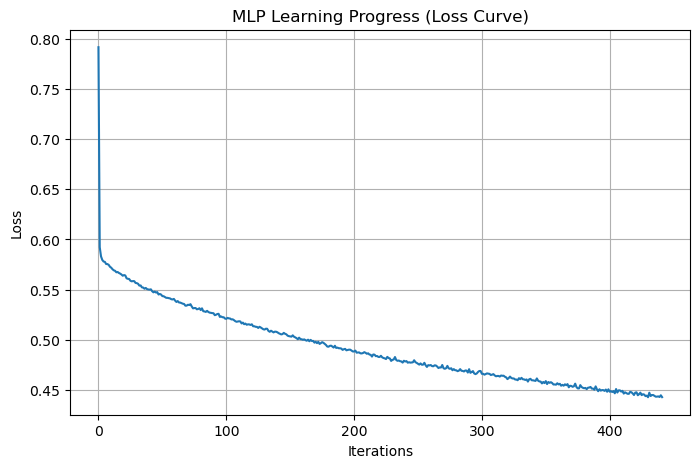

In [63]:
# MLP loss curve visualization
mlp_pipeline = Pipeline([
    ('prep', preprocessor),
    ('model', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        max_iter=500,
        random_state=42
    ))
])

mlp_pipeline.fit(X_train, y_train)
trained_mlp = mlp_pipeline.named_steps['model']

# Predictions for MLP
y_pred_mlp = mlp_pipeline.predict(X_test)

plt.figure(figsize=(8,5))
plt.plot(trained_mlp.loss_curve_)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("MLP Learning Progress (Loss Curve)")
plt.grid(True)
plt.show()

In [64]:
# Decision Tree visualization (Top Levels)
# Train Decision Tree pipeline
dt_pipeline = Pipeline([
    ('prep', preprocessor),
    ('model', DecisionTreeClassifier(
        max_depth=10,
        random_state=42
    ))
])

print(dt_pipeline.fit(X_train, y_train))


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'study_hours',
                                                   'class_attendance',
                                                   'sleep_hours',
                                                   'sleep_quality_mapped']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'course',
                                                   'study_method',
                                                   'internet_access'])])),
                ('model',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])


In [65]:
# Predictions for Decision Tree
y_pred_dt = dt_pipeline.predict(X_test)

In [66]:
# Extract feature names after encoding
num_features = num_cols

cat_features = dt_pipeline.named_steps['prep'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(cat_cols)

all_feature_names = np.concatenate([num_features, cat_features])

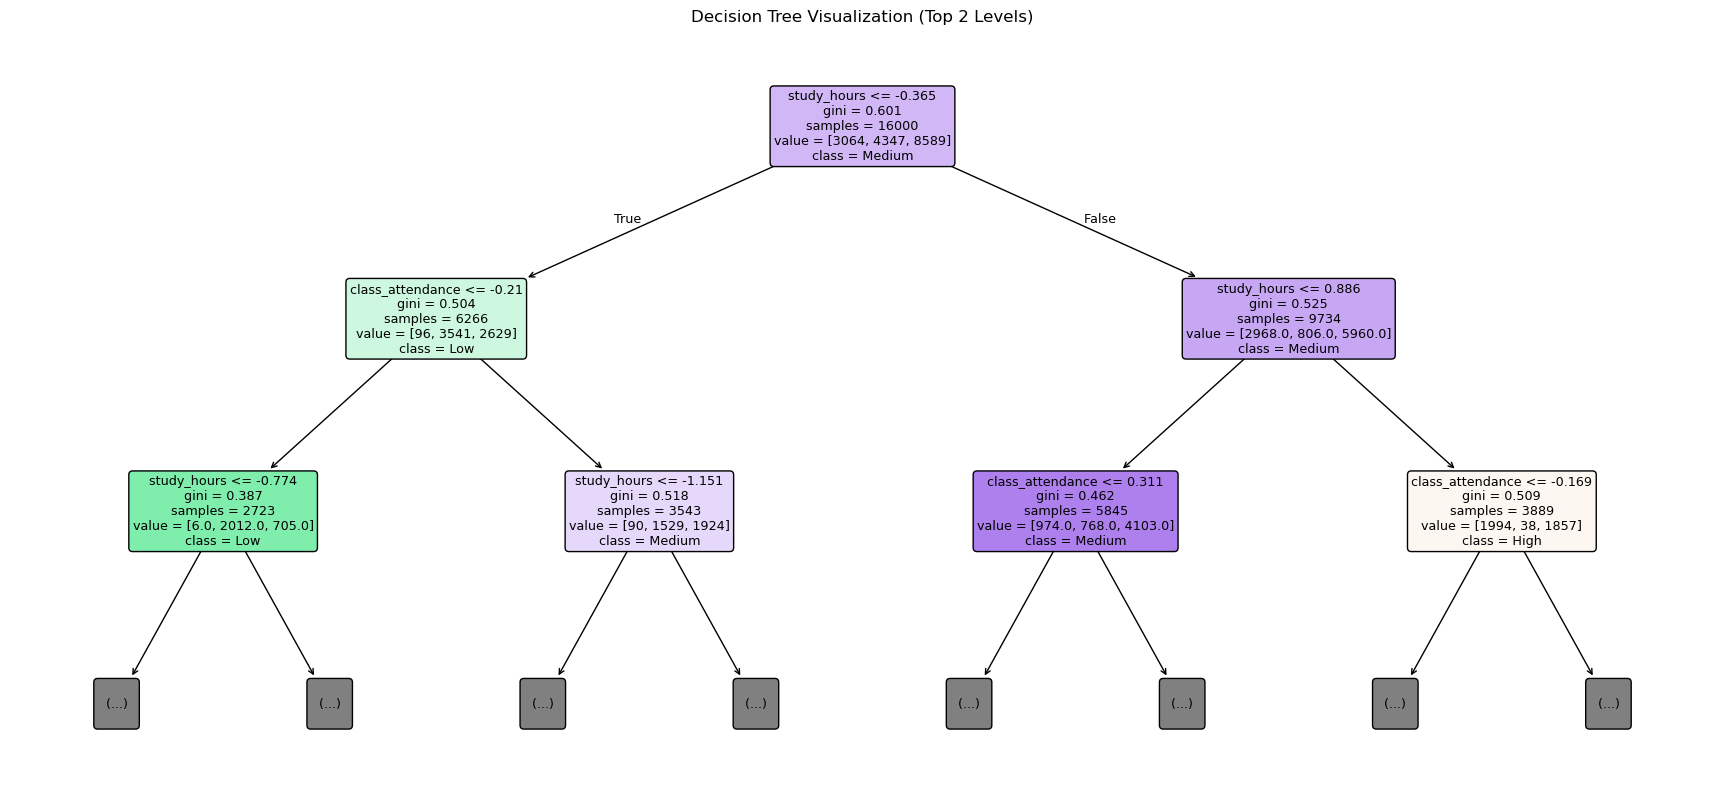

In [67]:
# Plot Decision Tree
dt_model = dt_pipeline.named_steps['model']

plt.figure(figsize=(22,10))
tree.plot_tree(
    dt_model,
    feature_names=all_feature_names,
    class_names=dt_model.classes_,
    max_depth=2,
    filled=True,
    rounded=True
)

plt.title("Decision Tree Visualization (Top 2 Levels)")
plt.show()

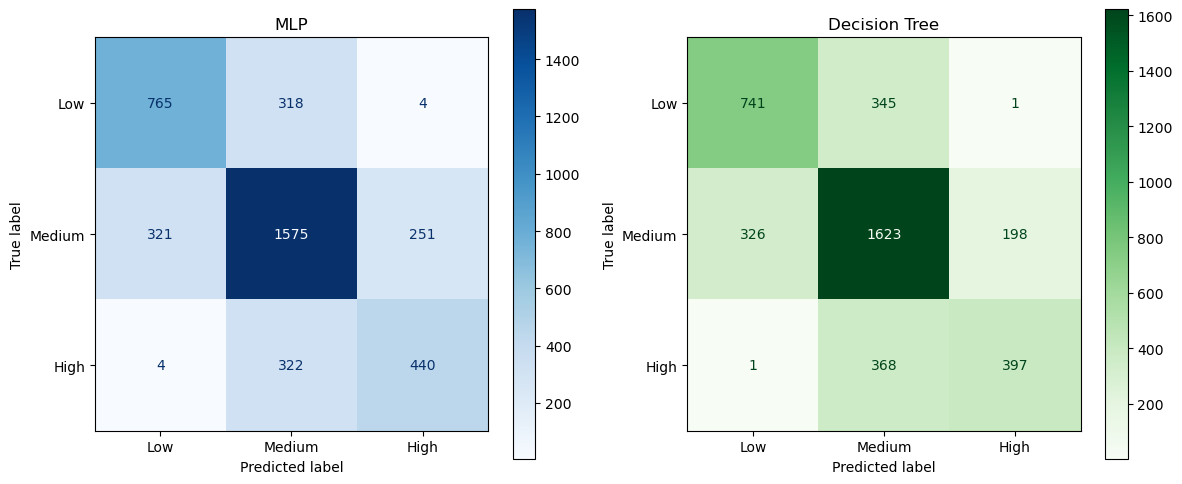

In [70]:
# Confusion Matrices
cm_mlp = confusion_matrix(y_test, y_pred_mlp, labels=labels)
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=labels)

# Comparing Confusion Matrix results for both models
fig, axes = plt.subplots(1, 2, figsize=(12,5))

ConfusionMatrixDisplay(cm_mlp, display_labels=labels) \
    .plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title("MLP")

ConfusionMatrixDisplay(cm_dt, display_labels=labels) \
    .plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title("Decision Tree")

plt.tight_layout()
plt.show()

### Results:

- MLP: Better pattern recognition for complex interactions
- Decision Tree: Easy to interpret, good for rules like:
    1. Low study hours + poor attendance -> Low performance
    2. High attendance + good sleep -> Medium/High performance
- Accuracy for both the models ~69%
- Confusion matrices help analyze misclassification patterns

## Future Enhancements
- Extend analysis using advanced ensemble models such as Random Forest or XGBoost
- Incorporate additional student data (e.g., assignments, extracurricular activities)
- Perform hyperparameter tuning for improved model performance
- Explore fairness and bias considerations in educational predictions